# YZ Proje Ödevi: Genetik Algoritma (Senaryo 3)
**Adı Soyadı:** ...
**Numara:** ...
**Github Linki:** (Burayı GitHub'a yükleyince dolduracaksın)

## 1. Kütüphaneler ve Sabit Değerler
Genetik algoritmanın çalışması için gerekli kütüphaneler eklenmiştir.
Senaryo 3 için belirlenen sınırlar şöyledir:
* **Hız ($x_1$):** [60, 100] (Kısıt gereği alt sınır 40 yerine 60 alındı)
* **Kapasite ($x_2$):** [2, 10]

In [1]:
import random
import matplotlib.pyplot as plt

# --- GENETİK ALGORİTMA PARAMETRELERİ ---
# Bu değerlerle oynayarak sonucu iyileştirmeyi deneyebilirsin.
POPULATION_SIZE = 50    # Her nesildeki birey sayısı
GENERATIONS = 100       # Kaç kuşak boyunca evrimleşecek
MUTATION_RATE = 0.10    # Mutasyon olma ihtimali (%10)
ELITISM_COUNT = 2       # En iyi 2 birey bozulmadan sonraki nesle geçsin

# --- SENARYO 3 DEĞİŞKEN SINIRLARI ---
# x1: Ortalama Hız (km/h). Normalde [40, 100] verilmiş.
# ANCAK: Kısıt kısmında "x1 >= 60" denildiği için alt sınırı 60 alıyoruz.
X1_MIN = 60
X1_MAX = 100

# x2: Araç Yük Kapasitesi (ton). [2, 10]
X2_MIN = 2
X2_MAX = 10

## 2. Birey Oluşturma ve Fitness (Uygunluk) Hesabı
Her birey `[hız, kapasite]` şeklinde iki ondalıklı sayıdan (gen) oluşur.

**Ceza Yöntemi (Penalty Method):**
Problemde $x_1 \cdot x_2 \le 700$ (Motor Gücü) kısıtı vardır.
Eğer bir birey bu sınırı aşarsa, fitness fonksiyonu ona **-9999** puan vererek elenmesini sağlar.

In [2]:
def create_individual():
    """
    Rastgele başlangıç değerlerine sahip bir birey (kromozom) oluşturur.
    Dönen değer: [hiz, kapasite] şeklinde bir listedir.
    """
    # x1 için 60 ile 100 arasında rastgele ondalıklı sayı
    x1 = random.uniform(X1_MIN, X1_MAX)
    # x2 için 2 ile 10 arasında rastgele ondalıklı sayı
    x2 = random.uniform(X2_MIN, X2_MAX)
    return [x1, x2]

def calculate_fitness(individual):
    """
    Bireyin başarısını (skorunu) hesaplar.
    Senaryo 3 Formülü: y = -2x1 - 3x2 + 0.1*x1*x2
    """
    x1 = individual[0] # Hız
    x2 = individual[1] # Kapasite

    # --- KISIT KONTROLÜ (CONSTRAINT HANDLING) ---
    # Senaryo Kısıtı: x1 * x2 <= 700 (Motor Gücü Limiti)
    motor_gucu = x1 * x2

    if motor_gucu > 700:
        # Eğer motor gücü 700'ü aşarsa, bu çözüm GEÇERSİZDİR.
        # Algoritmaya bunu seçmemesi için çok düşük bir ceza puanı veriyoruz.
        return -9999

    # --- AMAÇ FONKSİYONU HESABI ---
    # Soruda verilen formülün aynısı:
    skor = (-2 * x1) - (3 * x2) + (0.1 * x1 * x2)

    return skor

## 3. Evrimsel Operatörler (Seçilim, Çaprazlama, Mutasyon)
* **Seçilim:** Turnuva yöntemiyle (rastgele 3 adaydan en iyisi) ebeveynler seçilir.
* **Çaprazlama:** Değişkenler sayısal olduğu için **Aritmetik Çaprazlama** (Ağırlıklı Ortalama) yöntemi kullanılır.
* **Mutasyon:** Genlere rastgele küçük değerler eklenir. Sınırları aşmaması için `max` ve `min` fonksiyonları ile düzeltilir (Clamping).

In [3]:
def tournament_selection(population):
    """
    Turnuva Seçimi: Rastgele 3 birey seç, en iyisini ebeveyn yap.
    Bu yöntem zayıf bireylerin seçilme şansını düşürür ama tamamen yok etmez.
    """
    sample = random.sample(population, 3) # 3 aday seç
    # Adayları fitness değerine göre büyükten küçüğe sırala
    sample.sort(key=lambda ind: calculate_fitness(ind), reverse=True)
    # En iyiyi (0. indeks) döndür
    return sample[0]

def crossover(parent1, parent2):
    """
    Çaprazlama (Crossover): İki ebeveynin genlerini karıştırarak çocuk üretir.
    Aritmetik çaprazlama kullanıyoruz (Ortalama alma yöntemi).
    """
    # alpha: Genlerin ne kadarının anneden ne kadarının babadan geleceğini belirler.
    alpha = random.random()

    # Hız (x1) genini harmanla
    child_x1 = alpha * parent1[0] + (1 - alpha) * parent2[0]

    # Kapasite (x2) genini harmanla
    child_x2 = alpha * parent1[1] + (1 - alpha) * parent2[1]

    return [child_x1, child_x2]

def mutation(individual):
    """
    Mutasyon: Çeşitliliği artırmak için genlerde ufak rastgele oynamalar yap.
    """
    # x1 (Hız) geni için mutasyon kontrolü
    if random.random() < MUTATION_RATE:
        degisim = random.uniform(-2, 2) # Hıza -2 ile +2 arası ekle
        individual[0] += degisim
        # Sınırları aştıysa düzelt (Clamping)
        individual[0] = max(X1_MIN, min(X1_MAX, individual[0]))

    # x2 (Kapasite) geni için mutasyon kontrolü
    if random.random() < MUTATION_RATE:
        degisim = random.uniform(-0.5, 0.5) # Kapasiteye ufak değişim
        individual[1] += degisim
        # Sınırları aştıysa düzelt
        individual[1] = max(X2_MIN, min(X2_MAX, individual[1]))

    return individual

## 4. Ana Döngü ve Sonuçların Görselleştirilmesi
Algoritma belirlenen nesil sayısı kadar çalıştırılır.
Her nesilde:
1.  Bireyler puana göre sıralanır.
2.  En iyi 2 birey doğrudan sonraki nesle aktarılır (**Elitizm**).
3.  Geri kalan bireyler seçilim, çaprazlama ve mutasyon ile üretilir.
4.  En iyi skorlar grafikte gösterilir.

Genetik Algoritma Başlıyor...
Nesil 0: En İyi Skor = -94.0293
Nesil 20: En İyi Skor = -90.0000
Nesil 40: En İyi Skor = -90.0000
Nesil 60: En İyi Skor = -90.0000
Nesil 80: En İyi Skor = -90.0000

--- OPTİMİZASYON TAMAMLANDI ---
En İyi Hız (x1) Değeri      : 60.00 km/h
En İyi Kapasite (x2) Değeri : 10.00 ton
Maksimum Amaç Fonksiyonu (y): -90.0000
Motor Gücü (x1*x2)          : 600.00 (Sınır: 700)
SONUÇ: Kısıtlar sağlanıyor, çözüm geçerli ✅


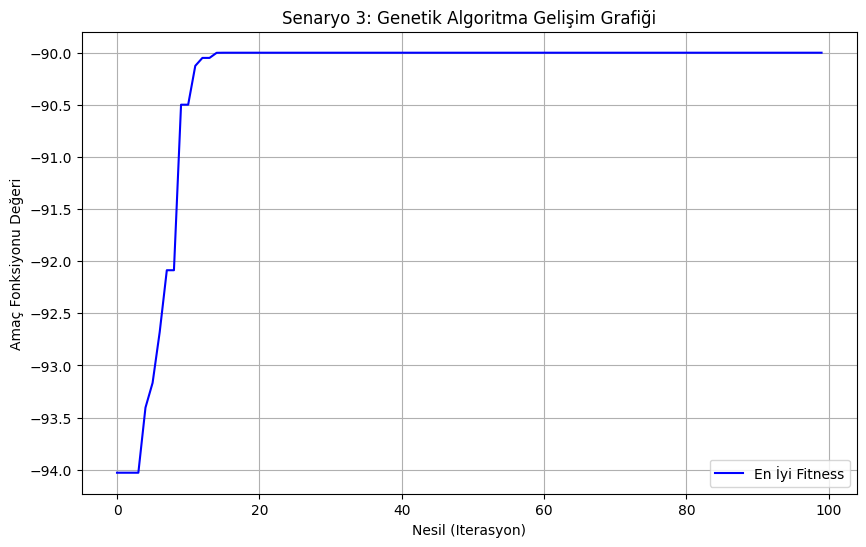

In [4]:
# --- BAŞLANGIÇ POPÜLASYONU ---
# İlk nesli rastgele oluşturuyoruz
population = [create_individual() for _ in range(POPULATION_SIZE)]

# Grafik çizimi için en iyi skorları tutacağımız liste
best_scores_history = []

print("Genetik Algoritma Başlıyor...")

# --- EVRİM DÖNGÜSÜ ---
for gen in range(GENERATIONS):
    # 1. Mevcut popülasyonu fitness değerine göre sırala (En iyi en üstte)
    population.sort(key=lambda ind: calculate_fitness(ind), reverse=True)

    # 2. O neslin en iyisini kaydet
    best_individual = population[0]
    best_fitness = calculate_fitness(best_individual)
    best_scores_history.append(best_fitness)

    # Her 20 nesilde bir ekrana bilgi yaz (Takip amaçlı)
    if gen % 20 == 0:
        print(f"Nesil {gen}: En İyi Skor = {best_fitness:.4f}")

    # 3. Yeni nesil oluşturma
    new_population = []

    # Elitizm: En iyi bireyleri doğrudan yeni nesle aktar (Kaybolmasınlar)
    new_population.extend(population[:ELITISM_COUNT])

    # Geri kalan popülasyonu çaprazlama ve mutasyonla doldur
    while len(new_population) < POPULATION_SIZE:
        # İki ebeveyn seç
        parent1 = tournament_selection(population)
        parent2 = tournament_selection(population)

        # Çocuğu üret
        child = crossover(parent1, parent2)

        # Mutasyona uğrat
        child = mutation(child)

        # Yeni popülasyona ekle
        new_population.append(child)

    # Eski popülasyonu yenisiyle değiştir
    population = new_population

# --- SONUÇLARI YAZDIRMA ---
# Son kez sırala ki en iyiyi alabilelim
population.sort(key=lambda ind: calculate_fitness(ind), reverse=True)
final_best = population[0]

print("\n--- OPTİMİZASYON TAMAMLANDI ---")
print(f"En İyi Hız (x1) Değeri      : {final_best[0]:.2f} km/h")
print(f"En İyi Kapasite (x2) Değeri : {final_best[1]:.2f} ton")
print(f"Maksimum Amaç Fonksiyonu (y): {calculate_fitness(final_best):.4f}")

# Kısıt Kontrolü (Sağlama)
motor_kontrol = final_best[0] * final_best[1]
print(f"Motor Gücü (x1*x2)          : {motor_kontrol:.2f} (Sınır: 700)")
if motor_kontrol <= 700:
    print("SONUÇ: Kısıtlar sağlanıyor, çözüm geçerli ✅")
else:
    print("SONUÇ: Kısıt ihlali var! ❌")

# --- GRAFİK ÇİZİMİ ---
plt.figure(figsize=(10, 6))
plt.plot(best_scores_history, label="En İyi Fitness", color='blue')
plt.title("Senaryo 3: Genetik Algoritma Gelişim Grafiği")
plt.xlabel("Nesil (Iterasyon)")
plt.ylabel("Amaç Fonksiyonu Değeri")
plt.legend()
plt.grid(True)
plt.show()